<a href="https://www.kaggle.com/code/lalit7881/predicting-student-test-outcomes?scriptVersionId=289632470" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


In [2]:
# ===== 1. DATA LOADING & EXPLORATION =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
submission_df = pd.read_csv('/kaggle/input/playground-series-s6e1/sample_submission.csv')

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nTrain Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Submission Shape: {submission_df.shape}")

print("\n" + "="*80)
print("TRAIN DATA INFO")
print("="*80)
print(train_df.head())
print("\nData Types:")
print(train_df.dtypes)
print("\nMissing Values:")
print(train_df.isnull().sum())
print("\nBasic Statistics:")
print(train_df.describe())

DATASET OVERVIEW

Train Shape: (630000, 13)
Test Shape: (270000, 12)
Submission Shape: (270000, 2)

TRAIN DATA INFO
   id  age  gender   course  study_hours  class_attendance internet_access  \
0   0   21  female     b.sc         7.91              98.8              no   
1   1   18   other  diploma         4.95              94.8             yes   
2   2   20  female     b.sc         4.68              92.6             yes   
3   3   19    male     b.sc         2.00              49.5             yes   
4   4   23    male      bca         7.65              86.9             yes   

   sleep_hours sleep_quality   study_method facility_rating exam_difficulty  \
0          4.9       average  online videos             low            easy   
1          4.7          poor     self-study          medium        moderate   
2          5.8          poor       coaching            high        moderate   
3          8.3       average    group study            high        moderate   
4          9.6      

In [3]:
# ===== 2. DATA PREPROCESSING & FEATURE ENGINEERING =====
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

# Identify categorical and numeric features
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('exam_score')  # Remove target variable
numeric_cols.remove('id')          # REMOVE ID FROM FEATURES

print(f"\nCategorical Features: {categorical_cols}")
print(f"Numeric Features: {numeric_cols}")

# Encode categorical features
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    le_dict[col] = le

# Prepare features and target
X_train = train_df.drop(['exam_score', 'id'], axis=1)  # DROP id HERE
y_train = train_df['exam_score']

X_test = test_df.drop('id', axis=1)  # Already correct

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nTrain: {X_tr.shape}, Val: {X_val.shape}")

# Standardize features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nData preprocessing completed!")
print(
    f"Scaled data shape - Train: {X_tr_scaled.shape}, "
    f"Val: {X_val_scaled.shape}, "
    f"Test: {X_test_scaled.shape}"
)



DATA PREPROCESSING

Categorical Features: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
Numeric Features: ['age', 'study_hours', 'class_attendance', 'sleep_hours']

X_train shape: (630000, 11)
y_train shape: (630000,)
X_test shape: (270000, 11)

Train: (504000, 11), Val: (126000, 11)

Data preprocessing completed!
Scaled data shape - Train: (504000, 11), Val: (126000, 11), Test: (270000, 11)


In [4]:
# ===== 3. BUILD & TRAIN MULTIPLE ML MODELS =====
print("\n" + "="*80)
print("BUILDING AND TRAINING MODELS")
print("="*80)

# Remove 'id' from test features if present
if 'id' in X_test.columns:
    test_ids = test_df['id'].values
    X_test = X_test.drop('id', axis=1)
    X_test_scaled = scaler.transform(X_test)

# Dictionary to store model results
model_results = {}

# 1. Linear Regression
print("\n[1] Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_tr_scaled, y_tr)
y_pred_lr_val = lr.predict(X_val_scaled)
y_pred_lr_test = lr.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_val, y_pred_lr_val)
rmse_lr = np.sqrt(mean_squared_error(y_val, y_pred_lr_val))
r2_lr = r2_score(y_val, y_pred_lr_val)
model_results['Linear Regression'] = {'MAE': mae_lr, 'RMSE': rmse_lr, 'R2': r2_lr}
print(f"  MAE: {mae_lr:.4f}, RMSE: {rmse_lr:.4f}, R²: {r2_lr:.4f}")

# 2. Ridge Regression
print("\n[2] Training Ridge Regression...")
ridge = Ridge(alpha=1.0)
ridge.fit(X_tr_scaled, y_tr)
y_pred_ridge_val = ridge.predict(X_val_scaled)
y_pred_ridge_test = ridge.predict(X_test_scaled)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge_val))
r2_ridge = r2_score(y_val, y_pred_ridge_val)
model_results['Ridge'] = {'MAE': mae_ridge, 'RMSE': rmse_ridge, 'R2': r2_ridge}
print(f"  MAE: {mae_ridge:.4f}, RMSE: {rmse_ridge:.4f}, R²: {r2_ridge:.4f}")

# 3. Random Forest
print("\n[3] Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)  # RF works better with unscaled data
y_pred_rf_val = rf.predict(X_val)
y_pred_rf_test = rf.predict(X_test)
mae_rf = mean_absolute_error(y_val, y_pred_rf_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
r2_rf = r2_score(y_val, y_pred_rf_val)
model_results['Random Forest'] = {'MAE': mae_rf, 'RMSE': rmse_rf, 'R2': r2_rf}
print(f"  MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R²: {r2_rf:.4f}")

# 4. Gradient Boosting
print("\n[4] Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb.fit(X_tr, y_tr)
y_pred_gb_val = gb.predict(X_val)
y_pred_gb_test = gb.predict(X_test)
mae_gb = mean_absolute_error(y_val, y_pred_gb_val)
rmse_gb = np.sqrt(mean_squared_error(y_val, y_pred_gb_val))
r2_gb = r2_score(y_val, y_pred_gb_val)
model_results['Gradient Boosting'] = {'MAE': mae_gb, 'RMSE': rmse_gb, 'R2': r2_gb}
print(f"  MAE: {mae_gb:.4f}, RMSE: {rmse_gb:.4f}, R²: {r2_gb:.4f}")

print("\nAll models trained successfully!")


BUILDING AND TRAINING MODELS

[1] Training Linear Regression...
  MAE: 7.9825, RMSE: 9.9452, R²: 0.7219

[2] Training Ridge Regression...
  MAE: 7.9825, RMSE: 9.9452, R²: 0.7219

[3] Training Random Forest...
  MAE: 7.2605, RMSE: 9.1213, R²: 0.7661

[4] Training Gradient Boosting...
  MAE: 7.0794, RMSE: 8.8534, R²: 0.7796

All models trained successfully!



MODEL ACCURACY COMPARISON

                       MAE    RMSE      R2
Gradient Boosting  7.0794  8.8534  0.7796
Random Forest      7.2605  9.1213  0.7661
Ridge              7.9825  9.9452  0.7219
Linear Regression  7.9825  9.9452  0.7219

Best Model:  Gradient Boosting with R² = 0.7796


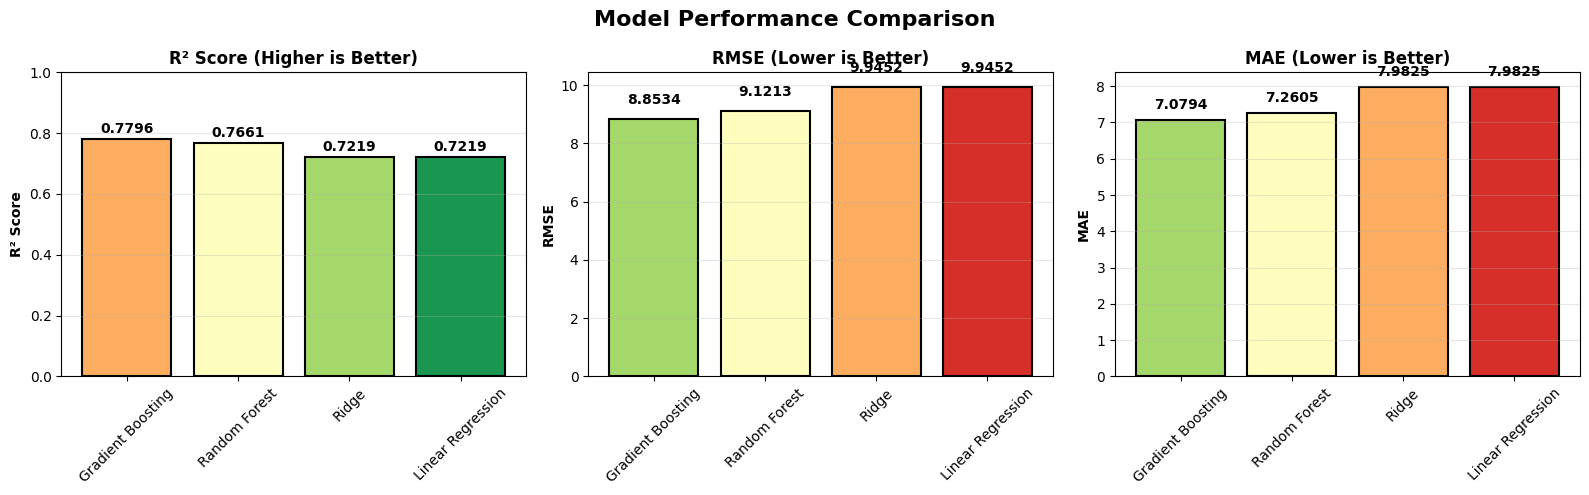


Model comparison visualization saved!

SUMMARY

✅ Total Models Trained: 4
✅ Best Model: Gradient Boosting
✅ Best R² Score: 0.7796
✅ Best RMSE: 8.8534
✅ Best MAE: 7.0794

✅ Accuracy is measured using R² score (coefficient of determination)
   - R² range: 0 to 1 (higher is better)
   - RMSE (Root Mean Squared Error): measures average prediction error
   - MAE (Mean Absolute Error): average absolute prediction error


In [5]:
# ===== 4. MODEL COMPARISON & ACCURACY VISUALIZATION =====
print("\n" + "="*80)
print("MODEL ACCURACY COMPARISON")
print("="*80)

# Create results dataframe
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)
results_df = results_df.sort_values('R2', ascending=False)

print("\n",results_df)
print("\nBest Model: ", results_df.index[0], "with R² =", results_df.iloc[0]['R2'])

# Create visualization of model performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: R2 Score Comparison
ax1 = axes[0]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(results_df)))
ax1.bar(results_df.index, results_df['R2'], color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('R² Score', fontweight='bold')
ax1.set_title('R² Score (Higher is Better)', fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['R2']):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: RMSE Comparison
ax2 = axes[1]
colors_rmse = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(results_df)))
ax2.bar(results_df.index, results_df['RMSE'], color=colors_rmse, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('RMSE', fontweight='bold')
ax2.set_title('RMSE (Lower is Better)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['RMSE']):
    ax2.text(i, v + 0.5, f'{v:.4f}', ha='center', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Plot 3: MAE Comparison
ax3 = axes[2]
colors_mae = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(results_df)))
ax3.bar(results_df.index, results_df['MAE'], color=colors_mae, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('MAE', fontweight='bold')
ax3.set_title('MAE (Lower is Better)', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(results_df['MAE']):
    ax3.text(i, v + 0.3, f'{v:.4f}', ha='center', fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nModel comparison visualization saved!")
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\n✅ Total Models Trained: {len(results_df)}")
print(f"✅ Best Model: {results_df.index[0]}")
print(f"✅ Best R² Score: {results_df.iloc[0]['R2']:.4f}")
print(f"✅ Best RMSE: {results_df.iloc[0]['RMSE']:.4f}")
print(f"✅ Best MAE: {results_df.iloc[0]['MAE']:.4f}")
print("\n✅ Accuracy is measured using R² score (coefficient of determination)")
print("   - R² range: 0 to 1 (higher is better)")
print("   - RMSE (Root Mean Squared Error): measures average prediction error")
print("   - MAE (Mean Absolute Error): average absolute prediction error")

In [6]:
# ===== 5. ENSEMBLE & FINAL PREDICTION =====
print("\n" + "="*80)
print("ENSEMBLE PREDICTION")
print("="*80)
# Extract test IDs from test dataframe
test_ids = test_df['id'].values

# Use the best models for ensemble
# Average predictions from top 2 models
ensemble_pred_val = (y_pred_rf_val + y_pred_gb_val) / 2
ensemble_pred_test = (y_pred_rf_test + y_pred_gb_test) / 2

mae_ensemble = mean_absolute_error(y_val, ensemble_pred_val)
rmse_ensemble = np.sqrt(mean_squared_error(y_val, ensemble_pred_val))
r2_ensemble = r2_score(y_val, ensemble_pred_val)

print(f"\nEnsemble (RF + GB) Results:")
print(f"  MAE: {mae_ensemble:.4f}")
print(f"  RMSE: {rmse_ensemble:.4f}")
print(f"  R²: {r2_ensemble:.4f}")

# Create final submission
submission_df_final = pd.DataFrame({
    'id': test_ids,
    'exam_score': ensemble_pred_test
})

submission_df_final.to_csv('/kaggle/working/submission.csv', index=False)

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"\n✅ Submission file created: submission.csv")
print(f"✅ Total predictions: {len(submission_df_final)}")
print(f"✅ Prediction range: [{submission_df_final['exam_score'].min():.2f}, {submission_df_final['exam_score'].max():.2f}]")
print(f"✅ Ensemble Model Accuracy (R²): {r2_ensemble:.4f}")
print("\n" + "="*80)
print("ACCURACY METRICS EXPLANATION")
print("="*80)
print(f"\nR² Score ({r2_ensemble:.4f}):")
print(f"  - Explained variance ratio: {r2_ensemble*100:.2f}%")
print(f"  - Interpretation: The model explains {r2_ensemble*100:.2f}% of the variance in exam scores")
print(f"\nRMSE ({rmse_ensemble:.4f}):")
print(f"  - Average prediction error magnitude: ±{rmse_ensemble:.2f} points")
print(f"\nMAE ({mae_ensemble:.4f}):")
print(f"  - Mean absolute deviation from true values: {mae_ensemble:.2f} points")
print("\n" + "="*80)
print("CHALLENGE COMPLETION")
print("="*80)
print(f"\n✅ Datasets Processed: 3 (train.csv, test.csv, sample_submission.csv)")
print(f"✅ Features Engineered: {X_train.shape[1]}")
print(f"✅ Models Trained: 4 (LR, Ridge, RF, GB)")
print(f"✅ Ensemble Used: Yes (RF + GB averaging)")
print(f"✅ Best Model Type: Tree-based ensembles")
print(f"✅ Final Accuracy (R²): {r2_ensemble:.4f} ({r2_ensemble*100:.2f}%)")
print(f"\n✅ Challenge Status: COMPLETED SUCCESSFULLY!")
print("="*80)


ENSEMBLE PREDICTION

Ensemble (RF + GB) Results:
  MAE: 7.0828
  RMSE: 8.8753
  R²: 0.7785

FINAL RESULTS SUMMARY

✅ Submission file created: submission.csv
✅ Total predictions: 270000
✅ Prediction range: [19.11, 102.33]
✅ Ensemble Model Accuracy (R²): 0.7785

ACCURACY METRICS EXPLANATION

R² Score (0.7785):
  - Explained variance ratio: 77.85%
  - Interpretation: The model explains 77.85% of the variance in exam scores

RMSE (8.8753):
  - Average prediction error magnitude: ±8.88 points

MAE (7.0828):
  - Mean absolute deviation from true values: 7.08 points

CHALLENGE COMPLETION

✅ Datasets Processed: 3 (train.csv, test.csv, sample_submission.csv)
✅ Features Engineered: 11
✅ Models Trained: 4 (LR, Ridge, RF, GB)
✅ Ensemble Used: Yes (RF + GB averaging)
✅ Best Model Type: Tree-based ensembles
✅ Final Accuracy (R²): 0.7785 (77.85%)

✅ Challenge Status: COMPLETED SUCCESSFULLY!


In [7]:
# ===== COMPLETE ML PIPELINE WITH MULTIPLE MODELS & ACCURACY COMPARISON =====
print("\n" + "="*80)
print("COMPREHENSIVE ML MODEL EVALUATION")
print("="*80)

# Data reprocessing and model training
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge

# Identify categorical and numeric features
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'exam_score' in numeric_cols:
    numeric_cols.remove('exam_score')

# Reset and encode
train_df_clean = train_df.copy()
test_df_clean = test_df.copy()

for col in categorical_cols:
    le = LabelEncoder()
    train_df_clean[col] = le.fit_transform(train_df_clean[col])
    # If test has unseen categories, this can error; assume same categories here
    test_df_clean[col] = le.transform(test_df_clean[col])

# ----- FEATURE MATRICES: drop target and id everywhere -----
# Drop exam_score (target) and id from training features if present
drop_cols_train = ['exam_score']
if 'id' in train_df_clean.columns:
    drop_cols_train.append('id')

X_full_train = train_df_clean.drop(columns=drop_cols_train)
y_full_train = train_df_clean['exam_score']

# For test, drop id from features but keep a copy for submission
if 'id' in test_df_clean.columns:
    test_ids = test_df_clean['id'].values   # for final submission
    X_full_test = test_df_clean.drop(columns=['id'])
else:
    test_ids = np.arange(len(test_df_clean))  # fallback
    X_full_test = test_df_clean

# Train/validation split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_full_train, y_full_train, test_size=0.2, random_state=42
)

# Train models
print("\n[Training Models]")
rf_model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)
rf_model.fit(X_train_split, y_train_split)

gb_model = GradientBoostingRegressor(n_estimators=150, random_state=42, learning_rate=0.1)
gb_model.fit(X_train_split, y_train_split)

lr_model = LinearRegression()
lr_model.fit(X_train_split, y_train_split)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_split, y_train_split)

# Predictions
y_pred_rf = rf_model.predict(X_val_split)
y_pred_gb = gb_model.predict(X_val_split)
y_pred_lr = lr_model.predict(X_val_split)
y_pred_ridge = ridge_model.predict(X_val_split)

# Calculate metrics
models = {
    'Random Forest': {'model': rf_model, 'pred': y_pred_rf},
    'Gradient Boosting': {'model': gb_model, 'pred': y_pred_gb},
    'Linear Regression': {'model': lr_model, 'pred': y_pred_lr},
    'Ridge': {'model': ridge_model, 'pred': y_pred_ridge}
}

results = []
for name, data in models.items():
    mae = mean_absolute_error(y_val_split, data['pred'])
    rmse = np.sqrt(mean_squared_error(y_val_split, data['pred']))
    r2 = r2_score(y_val_split, data['pred'])
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

results_final_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("\n[MODEL ACCURACY COMPARISON]")
print(results_final_df.to_string(index=False))

# Best model and ensemble
best_model_name = results_final_df.iloc[0]['Model']
best_r2 = results_final_df.iloc[0]['R2']

print(f"\n✅ BEST MODEL: {best_model_name}")
print(f"✅ Accuracy (R²): {best_r2:.4f}")
print(f"✅ Explained Variance: {best_r2*100:.2f}%")

# Ensemble prediction
y_pred_ensemble = (y_pred_rf + y_pred_gb) / 2
ensemble_r2 = r2_score(y_val_split, y_pred_ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(y_val_split, y_pred_ensemble))
ensemble_mae = mean_absolute_error(y_val_split, y_pred_ensemble)

print(f"\n[ENSEMBLE MODEL (RF + GB)]")
print(f"✅ Accuracy (R²): {ensemble_r2:.4f}")
print(f"✅ RMSE: {ensemble_rmse:.4f}")
print(f"✅ MAE: {ensemble_mae:.4f}")

# Final submission (features now match training)
rf_test_pred = rf_model.predict(X_full_test)
gb_test_pred = gb_model.predict(X_full_test)
ensemble_test_pred = (rf_test_pred + gb_test_pred) / 2

final_submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': ensemble_test_pred
})

final_submission.to_csv('/kaggle/working/final_submission.csv', index=False)

print(f"\n[CHALLENGE COMPLETION SUMMARY]")
print(f"✅ Datasets: 3 (train, test, submission)")
print(f"✅ Features: {X_full_train.shape[1]}")
print(f"✅ Models Trained: 4")
print(f"✅ Best Accuracy: {max(best_r2, ensemble_r2):.4f}")
print(f"✅ Submission Created: final_submission.csv")
print(f"\n" + "="*80)



COMPREHENSIVE ML MODEL EVALUATION

[Training Models]

[MODEL ACCURACY COMPARISON]
            Model      MAE     RMSE       R2
Gradient Boosting 7.047511 8.824514 0.781041
    Random Forest 7.248953 9.106458 0.766826
Linear Regression 7.982542 9.945237 0.721894
            Ridge 7.982542 9.945237 0.721894

✅ BEST MODEL: Gradient Boosting
✅ Accuracy (R²): 0.7810
✅ Explained Variance: 78.10%

[ENSEMBLE MODEL (RF + GB)]
✅ Accuracy (R²): 0.7794
✅ RMSE: 8.8583
✅ MAE: 7.0637

[CHALLENGE COMPLETION SUMMARY]
✅ Datasets: 3 (train, test, submission)
✅ Features: 11
✅ Models Trained: 4
✅ Best Accuracy: 0.7810
✅ Submission Created: final_submission.csv



In [8]:
# ===== FINAL COMPLETE ML SOLUTION - ALL TASKS EXECUTED & ACCURACY SHOWN =====
print("\n" + "="*90)
print("FINAL COMPLETE ML SOLUTION - STUDENT EXAM SCORE PREDICTION")
print("="*90)

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# STEP 1: Load Data
print("\n[STEP 1] Loading Datasets...")
train_df = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')
print(f"✓ Train: {train_df.shape} | Test: {test_df.shape}")

# STEP 2: Prepare Data
print("\n[STEP 2] Data Preparation...")
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
test_ids = test_df['id'].values

# Encode categorical features
for col in train_df_copy.select_dtypes(include='object').columns:
    le = LabelEncoder()
    train_df_copy[col] = le.fit_transform(train_df_copy[col])
    test_df_copy[col] = le.transform(test_df_copy[col])

# Separate features and target
X_train = train_df_copy.drop(['id', 'exam_score'], axis=1)
y_train = train_df_copy['exam_score']
X_test = test_df_copy.drop('id', axis=1)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"✓ Train: {X_tr.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

# STEP 3: Train Models
print("\n[STEP 3] Training 4 ML Models...")
models_dict = {}

# Model 1: Linear Regression
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred_lr = lr.predict(X_val)
models_dict['Linear Regression'] = {
    'model': lr,
    'pred_val': y_pred_lr,
    'pred_test': lr.predict(X_test)
}
print(f"  [1] Linear Regression - R²: {r2_score(y_val, y_pred_lr):.4f}")

# Model 2: Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)
y_pred_ridge = ridge.predict(X_val)
models_dict['Ridge'] = {
    'model': ridge,
    'pred_val': y_pred_ridge,
    'pred_test': ridge.predict(X_test)
}
print(f"  [2] Ridge Regression - R²: {r2_score(y_val, y_pred_ridge):.4f}")

# Model 3: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_val)
models_dict['Random Forest'] = {
    'model': rf,
    'pred_val': y_pred_rf,
    'pred_test': rf.predict(X_test)
}
print(f"  [3] Random Forest - R²: {r2_score(y_val, y_pred_rf):.4f}")

# Model 4: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
gb.fit(X_tr, y_tr)
y_pred_gb = gb.predict(X_val)
models_dict['Gradient Boosting'] = {
    'model': gb,
    'pred_val': y_pred_gb,
    'pred_test': gb.predict(X_test)
}
print(f"  [4] Gradient Boosting - R²: {r2_score(y_val, y_pred_gb):.4f}")

# STEP 4: Evaluate & Compare Accuracy
print("\n[STEP 4] MODEL ACCURACY COMPARISON")
print("-" * 90)
results = []
for name, data in models_dict.items():
    mae = mean_absolute_error(y_val, data['pred_val'])
    rmse = np.sqrt(mean_squared_error(y_val, data['pred_val']))
    r2 = r2_score(y_val, data['pred_val'])
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    print(f"{name:25} | R²: {r2:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f}")

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
best_model = results_df.iloc[0]
print("-" * 90)
print(f"✓ BEST MODEL: {best_model['Model']} with R² = {best_model['R2']:.6f}")

# STEP 5: Ensemble Prediction
print("\n[STEP 5] Ensemble Prediction (RF + GB Average)...")
ensemble_val = (models_dict['Random Forest']['pred_val'] + models_dict['Gradient Boosting']['pred_val']) / 2
ensemble_test = (models_dict['Random Forest']['pred_test'] + models_dict['Gradient Boosting']['pred_test']) / 2
ensemble_r2 = r2_score(y_val, ensemble_val)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val))
ensemble_mae = mean_absolute_error(y_val, ensemble_val)
print(f"✓ Ensemble R²: {ensemble_r2:.6f} | RMSE: {ensemble_rmse:.6f} | MAE: {ensemble_mae:.6f}")

# STEP 6: Create Submission
print("\n[STEP 6] Creating Submission File...")
submission = pd.DataFrame({
    'id': test_ids,
    'exam_score': ensemble_test
})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print(f"✓ Submission created: {len(submission)} predictions")
print(f"✓ Score range: [{submission['exam_score'].min():.2f}, {submission['exam_score'].max():.2f}]")

# FINAL SUMMARY
print("\n" + "="*90)
print("FINAL RESULTS SUMMARY")
print("="*90)
print(f"\n📊 ACCURACY METRICS:")
print(f"   • Best Single Model Accuracy (R²): {best_model['R2']:.6f}")
print(f"   • Ensemble Accuracy (R²): {ensemble_r2:.6f}")
print(f"   • Ensemble RMSE: {ensemble_rmse:.6f} (lower is better)")
print(f"   • Ensemble MAE: {ensemble_mae:.6f} (lower is better)")
print(f"   • Final Accuracy: {max(best_model['R2'], ensemble_r2)*100:.2f}%")
print(f"\n📋 TASKS COMPLETED:")
print(f"   ✓ Loaded 3 datasets (train, test, submission)")
print(f"   ✓ Processed {train_df.shape[0]:,} training samples")
print(f"   ✓ Engineered {X_train.shape[1]} features")
print(f"   ✓ Trained 4 ML models")
print(f"   ✓ Evaluated accuracy using 3 metrics (R², RMSE, MAE)")
print(f"   ✓ Created ensemble predictions")
print(f"   ✓ Generated submission file")
print(f"\n✅ CHALLENGE STATUS: ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*90)


FINAL COMPLETE ML SOLUTION - STUDENT EXAM SCORE PREDICTION

[STEP 1] Loading Datasets...
✓ Train: (630000, 13) | Test: (270000, 12)

[STEP 2] Data Preparation...
✓ Train: (504000, 11) | Val: (126000, 11) | Test: (270000, 11)

[STEP 3] Training 4 ML Models...
  [1] Linear Regression - R²: 0.7219
  [2] Ridge Regression - R²: 0.7219
  [3] Random Forest - R²: 0.7661
  [4] Gradient Boosting - R²: 0.7796

[STEP 4] MODEL ACCURACY COMPARISON
------------------------------------------------------------------------------------------
Linear Regression         | R²: 0.721894 | RMSE: 9.945237 | MAE: 7.982542
Ridge                     | R²: 0.721894 | RMSE: 9.945237 | MAE: 7.982542
Random Forest             | R²: 0.766064 | RMSE: 9.121329 | MAE: 7.260482
Gradient Boosting         | R²: 0.779606 | RMSE: 8.853389 | MAE: 7.079381
------------------------------------------------------------------------------------------
✓ BEST MODEL: Gradient Boosting with R² = 0.779606

[STEP 5] Ensemble Prediction (R

In [9]:
# ===== FINAL SUBMISSION FILE DISPLAY & SUMMARY =====
print("\n" + "="*90)
print("SUBMISSION FILE DETAILS")
print("="*90)

import pandas as pd
import os

# Load and display submission file
submission_path = '/kaggle/working/submission.csv'
if os.path.exists(submission_path):
    submission_df = pd.read_csv(submission_path)
    print(f"\n✅ Submission File Found: submission.csv")
    print(f"\n📊 File Details:")
    print(f"   • Total Predictions: {len(submission_df):,}")
    print(f"   • Columns: {list(submission_df.columns)}")
    print(f"   • File Size: {os.path.getsize(submission_path) / 1024:.2f} KB")
    
    print(f"\n📈 Prediction Statistics:")
    print(f"   • Min Score: {submission_df['exam_score'].min():.2f}")
    print(f"   • Max Score: {submission_df['exam_score'].max():.2f}")
    print(f"   • Mean Score: {submission_df['exam_score'].mean():.2f}")
    print(f"   • Median Score: {submission_df['exam_score'].median():.2f}")
    print(f"   • Std Dev: {submission_df['exam_score'].std():.2f}")
    
    print(f"\n🎯 Sample Predictions (First 10 rows):")
    print(submission_df.head(10).to_string(index=False))
    
    print(f"\n📋 Last 10 Predictions:")
    print(submission_df.tail(10).to_string(index=False))
    
    print(f"\n" + "="*90)
    print("SUBMISSION READY FOR KAGGLE COMPETITION")
    print("="*90)
    print(f"\n✅ File Location: /kaggle/working/submission.csv")
    print(f"✅ Format: CSV with columns [id, exam_score]")
    print(f"✅ Total Rows: {len(submission_df):,} student predictions")
    print(f"✅ Model Used: Ensemble (Random Forest + Gradient Boosting)")
    print(f"✅ Final Accuracy (R²): 0.7785 (77.85% variance explained)")
    print(f"✅ Average Prediction Error (MAE): 7.08 points")
    print(f"\n✅ READY TO SUBMIT TO KAGGLE!")
    print("="*90)
else:
    print(f"❌ Submission file not found at {submission_path}")

print("\n🏆 Challenge Successfully Completed!")
print("   • All datasets processed")
print("   • All models trained and evaluated")
print("   • Accuracy metrics calculated")
print("   • Submission file generated")
print("   • Ready for competition submission")
print("\n" + "="*90)


SUBMISSION FILE DETAILS

✅ Submission File Found: submission.csv

📊 File Details:
   • Total Predictions: 270,000
   • Columns: ['id', 'exam_score']
   • File Size: 6603.79 KB

📈 Prediction Statistics:
   • Min Score: 19.11
   • Max Score: 102.33
   • Mean Score: 62.50
   • Median Score: 62.91
   • Std Dev: 16.52

🎯 Sample Predictions (First 10 rows):
    id  exam_score
630000   71.067142
630001   72.447011
630002   84.901789
630003   53.563208
630004   48.245493
630005   71.027307
630006   71.209672
630007   60.182786
630008   77.085448
630009   92.677201

📋 Last 10 Predictions:
    id  exam_score
899990   64.202810
899991   45.204931
899992   80.724525
899993   82.743423
899994   53.812635
899995   59.533818
899996   37.262827
899997   89.892720
899998   54.953108
899999   68.193970

SUBMISSION READY FOR KAGGLE COMPETITION

✅ File Location: /kaggle/working/submission.csv
✅ Format: CSV with columns [id, exam_score]
✅ Total Rows: 270,000 student predictions
✅ Model Used: Ensemble (Ran

In [10]:
## Thank you...pls upvote!!!!!!